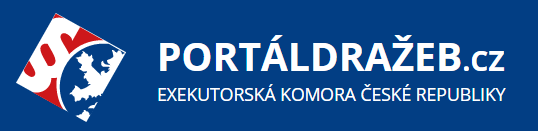

### Dynamic scraper
#### Goal
As the title suggests, the first section incorporates a data scraper. Its goal is to crawl through https://www.portaldrazeb.cz and to collect actual data about auctions and auctioneers. It also scrapes lists of auction attributes which we will subsequently use to filter the auctions with respect to location, type, etc.  
#### Problem
The problem is that the webpage has dynamic content and therefore we cannot easily extract the "static" source code as in other cases. The website also does not provide API (it actually does, however, not for us and not for the purposes we need). 
#### Solution
We use methods that handle the dynamic content - our solution is the installation of package *selenium* and setting up a *Google Chrome webdriver*. We basically open the webpage, collect its source code and navigate between pages. Thanks to this package (and the webdriver which is also included in the GitHub repository) we manage to download all the data we need. More detailed description of particular methods can be found in the class docstring and in the comments.

In [3]:
# importing the class which will do the scraping  
from dynamic_scraper import DataDownloader
down = DataDownloader() # initialising the scraper

Downloader successfully initialized!
 

    This class crawls through dynamic content of https://www.portaldrazeb.cz and collects following things:

            1) link to every auction + auction category (since the category is not within the auction page itself)
            2) list of all possible values from drop-down menu (auction categories, regions and districts)
    


In [4]:
# link we will need
url_auctions='https://www.portaldrazeb.cz/drazby/pripravovane'

The next lines of code will scrape the data. Please do not interact with the Google Chrome window that will open in the background, just wait until it does its job and closes. The whole procedure should take a bit over 20 minutes. 

In [5]:
down.get_auction_links_and_categories(url_auctions) # takes approx. 5 minutes

100%|██████████| 57/57 [04:57<00:00,  5.21s/it]


Auction links and categories successfully downloaded! There are 1127 auctions right now.


In [6]:
down.get_items_from_dropdown_menu(url_auctions) 

Auction categories, regions and districts successfully downloaded!


In [7]:
down.extract_auction_soups() # takes approx. 17 minutes

100%|██████████| 1127/1127 [11:40<00:00,  1.61it/s]

Soup objects successfully appended to auction_links_and_categories.


### Data processor
#### 

In [65]:
czech = {'\\u00e1': 'á',"\\u010d":"č","\\u010f":"ď","\\u00e9":"é","\\u011b":"ě","\\u00ed":"í","\\u0148":"ň","\\u00f3":"ó","\\u0159":"ř","\\u0161":"š","\\u0165":"ť","\\u00fa":"ú","\\u016f":"ů","\\u00fd":"ý","\\u017e":"ž","\\u00c1":"Á","\\u00c4":"Ä","\\u010c":"Č","\\u010e":"Ď","\\u00c9":"É","\\u011a":"Ě","\\u00cd":"Í","\\u0147":"Ň","\\u00d3":"Ó","\\u0158":"Ř","\\u0160":"Š","\\u0164":"Ť","\\u00da":"Ú","\\u016e":"Ů","\\u00dd":"Ý","\\u017d":"Ž"}
#necessary to translate groups of characters from the source code to Czech characters
for x,y in czech.items():
    auctiondata = auctiondata.replace(x, y)
auctiondata

'<div class="auction" data-auction=\'{"enabled":true,"bids":[],"location_district":null,"started":false,"finished":false,"hash":"74g1n","documents":{"wWlM9":{"pathname":"/auctions/74g1n/pdf1","mime_type":"application/pdf","size":134754,"original_name":"znalecký posudek 1.pdf","description":null,"created_at":"2020-07-22T05:59:09.926+00:00","updated_at":"2020-07-22T05:59:10.391+00:00","hash":"wWlM9","document_type":"expert_report"},"JpWYp":{"pathname":"/auctions/74g1n/pdf2","mime_type":"application/pdf","size":4061899,"original_name":"dražební vyhláška 1.pdf","description":null,"created_at":"2020-07-22T05:59:10.366+00:00","updated_at":"2020-07-22T05:59:10.432+00:00","hash":"JpWYp","document_type":"auction_decree"}},"images":{"WGYAp":{"pathname":"/auctions/74g1n/0","mime_type":"image/jpeg","size":39921,"original_name":"obrázek 1.jpg","description":null,"hash":"WGYAp","width":375,"height":274,"priority":0},"yY93Z":{"pathname":"/auctions/74g1n/1","mime_type":"image/jpeg","size":43594,"origi

In [66]:
auctionslist=[]
for i in range(len(down.auction_links_and_categories)):
    soup = down.auction_links_and_categories[i][2]
    auctiondata=soup.findAll("div", {"class": "auction"})
    auctiondata=str(auctiondata[0])
    for x,y in czech.items():
        auctiondata = auctiondata.replace(x, y)#here the source-Czech dictionary is used
    title=auctiondata[(auctiondata.index("item") + len("item")+12):]
    title=title[:title.index("category")-3]                                     
    auctioneer=auctiondata[(auctiondata.index("auctioneer_office") + len("auctioneer_office")+30):]
    auctioneer=auctioneer[:auctioneer.index("addresses")-3].split(" ") 
    number=auctiondata[(auctiondata.index('voluntary')-17):(auctiondata.index('voluntary')-3)].replace(':','').replace('"', '')
    estimated_price=auctiondata[(auctiondata.index("estimated_price") + len("estimated_price")+2):]
    estimated_price=estimated_price[:estimated_price.index("item_price")-2]
    reserve_price=auctiondata[auctiondata.index("item_price")+12:]
    reserve_price=reserve_price[:reserve_price.index("minimal_bid")-2]
    link = down.auction_links_and_categories[i][0]
    category = down.auction_links_and_categories[i][1][0]
    try: subcategory = down.auction_links_and_categories[i][1][1]
    except: subcategory = "-"
    
    auction=[]
    auction.extend([auctioneer[0],auctioneer[1],title,category,subcategory,number,estimated_price,reserve_price,link])
    auctionslist.append(auction)
    #print([i],sep=' ', end='', flush="true")writes how many auctions it processed, just to ensure it actually does something
    #takes a shitload of time to scrape it all(15 to 20 minutes, probably. The bottleneck is getting all those requests, so the only way to make it faster seems to be to buy better internet.)
    

In [9]:
import pandas as pd

In [67]:
auctions = pd.DataFrame(auctionslist)
auctions.columns = ["Surname","Name","Title of auction","Category","Subcategory","Auction code","Estimated price","Reserve price","link"]
auctions

,Surname,Name,Title of auction,Category,Subcategory,Auction code,Estimated price,Reserve price,link
0,Jaroš,Petr,"_district"":{""district_code"":40789,""district_na...",Movitosti,Auto-moto,29EX4106/19-74,24000,9680,https://www.portaldrazeb.cz/drazba/129ex4106-1...
1,Kocián,Petr,"_district"":{""district_code"":40851,""district_na...",Movitosti,Auto-moto,7EX13285/18-MG,680000,453333,https://www.portaldrazeb.cz/drazba/137ex13285-...
2,Ivanko,Igor,"_district"":{""district_code"":40606,""district_na...",Movitosti,Auto-moto,67EX194/13-272,99000,66000,https://www.portaldrazeb.cz/drazba/167ex194-13...
3,Voborník,Tomáš,"_district"":{""district_code"":40592,""district_na...",Movitosti,Auto-moto,195EX1414/20,1500000,1000000,https://www.portaldrazeb.cz/drazba/195ex1414-2...
4,Jaroš,Petr,"_district"":{""district_code"":40789,""district_na...",Movitosti,Auto-moto,29EX4106/19-76,3000,1210,https://www.portaldrazeb.cz/drazba/129ex4106-1...
...,...,...,...,...,...,...,...,...,...
1122,Bohutínský,Jan,"_district"":{""district_code"":40878,""district_na...",Nemovitosti,Rodinný dům,158EX129/14,435000,290000,https://www.portaldrazeb.cz/drazba/158ex129-14...
1123,Souček,Kamil,"_district"":{""district_code"":40169,""district_na...",Nemovitosti,Rodinný dům,083EX806/15-71,210000,0,https://www.portaldrazeb.cz/drazba/083ex806-15...
1124,Bohutínský,Jan,"_district"":{""district_code"":40606,""district_na...",Nemovitosti,Rodinný dům,158EX1248/13,1750000,1166667,https://www.portaldrazeb.cz/drazba/158ex1248-1...
1125,Tvrdková,Jana,"_district"":{""district_code"":40169,""district_na...",Nemovitosti,Rodinný dům,095EX2043/13,0,0,https://www.portaldrazeb.cz/drazba/095ex2043-1...


In [15]:
auctions.to_csv('auctionslist.csv')